In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['figure.dpi'] = 100

In [3]:
# Define some utility functions

def adjusted_count(x):
    return len(x) / num_countries

def plot_series_list(series_list, title=""):
    
    fig, axs = plt.subplots(len(series_list))
    fig.suptitle(title)
    y_label = "% of valid values"
    
    for i, s in enumerate(series_list):
        #axs[i].set_yticks(np.arange(0, 1, 0.1), minor=False)
        axs[i].title.set_text(s.name)
        axs[i].set_ylabel(y_label)
        axs[i].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
        axs[i].hlines(0.8, min(s.index), max(s.index), color='r')
        axs[i].plot(s.index[:-1], s.values[:-1], marker='x')
    
    fig.tight_layout(pad=1.0)
    
    return


# Economic indicators

In [4]:
data = pd.read_csv('data/Indicators.csv')
data.dropna()
data.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
0,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1960,1.335609e+02
1,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,1960,8.779760e+01
2,Arab World,ARB,"Age dependency ratio, old (% of working-age po...",SP.POP.DPND.OL,1960,6.634579e+00
3,Arab World,ARB,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,1960,8.102333e+01
4,Arab World,ARB,Arms exports (SIPRI trend indicator values),MS.MIL.XPRT.KD,1960,3.000000e+06


### 1. Drop data for composite regions

In [5]:
regions = data['CountryName'].unique()
num_composite_regions = len(regions)

# Get only individual regions
# Meaning countries in this context, except for some minor exceptions like Hong Kong

countries = regions[33:]
num_countries = len(countries)

In [6]:
print(f'Composite regions: {num_composite_regions}')
print(f'Individual regions: {num_countries}')

Composite regions: 247
Individual regions: 214


In [7]:
# Drop composite regions

data = data[data['CountryName'].isin(countries)]
print(len(data['CountryName'].unique()) == num_countries)

True


### 2. Study relevant indicators

In [8]:
# Find indicators related to GDP, CPI and unemployment numbers

#gdp_series_complete = indicators_table[indicators_table.index.str.contains("GDP")]
#unemployment_series_complete = indicators_table[indicators_table.index.str.contains("Unemployment")]
#price_index_series_complete = indicators_table[indicators_table.index.str.contains("price index")]

"""plot_series_list([gdp_series_complete,
                  unemployment_series_complete,
                  price_index_series_complete], 'Completeness of indicators over time')"""
s = "growth"
ind = [i for i in data['IndicatorName'].unique() if s in i] 
ind

['Population growth (annual %)',
 'Rural population growth (annual %)',
 'Urban population growth (annual %)',
 'Agriculture, value added (annual % growth)',
 'Exports of goods and services (annual % growth)',
 'Final consumption expenditure, etc. (annual % growth)',
 'GDP growth (annual %)',
 'GDP per capita growth (annual %)',
 'General government final consumption expenditure (annual % growth)',
 'GNI growth (annual %)',
 'GNI per capita growth (annual %)',
 'Gross capital formation (annual % growth)',
 'Household final consumption expenditure (annual % growth)',
 'Household final consumption expenditure per capita growth (annual %)',
 'Household final consumption expenditure, etc. (annual % growth)',
 'Imports of goods and services (annual % growth)',
 'Industry, value added (annual % growth)',
 'Gross fixed capital formation (annual % growth)',
 'Manufacturing, value added (annual % growth)',
 'Services, etc., value added (annual % growth)',
 'Adjusted net national income (annual 

In [9]:
# Define indicators we'll be using

relevant_indicators = {
    "gdp": 'GDP per capita (constant LCU)',
    "unemployment": 'Unemployment, total (% of total labor force)',
    "cpi": 'Consumer price index (2010 = 100)',
    "cgd": 'Central government debt, total (% of GDP)'
}

In [10]:
# Count valid indicators (along countries column), pivoting per indicator per year

data_table = data.pivot_table(index=['IndicatorName'], columns=['Year'], values='Value', aggfunc=adjusted_count)
data_table.fillna(value=0, inplace=True)

In [12]:
indicators = []

indicators.append(data_table.loc[relevant_indicators["gdp"], :])
indicators.append(data_table.loc[relevant_indicators["unemployment"], :])
indicators.append(data_table.loc[relevant_indicators["cpi"], :])

#plot_series_list(indicators, 'Completeness of indicators over time')

Looking at the graphs, it's visible there's a lot of incomplete data roughly before 1995.
All samples prior to 1995 will be dropped.
All samples for indicators that are not the 3 displayed above will also be dropped.

### 3. Build new dataset

In [58]:
# Drop unnecessary rows

economics_data = data[data['CountryName'].isin(countries)]
economics_data = economics_data[economics_data['IndicatorName'].isin(relevant_indicators.values())]
economics_data = economics_data[economics_data['Year'] >= 1995]
economics_data = economics_data.drop(columns=["CountryCode", "IndicatorCode"])
economics_data.rename(columns = {'Value':'IndicatorValue'}, inplace = True)
economics_data.head()

,CountryName,IndicatorName,Year,IndicatorValue
2502317,Afghanistan,"Unemployment, total (% of total labor force)",1995,8.500000
2502386,Albania,"Central government debt, total (% of GDP)",1995,35.288883
2502420,Albania,Consumer price index (2010 = 100),1995,40.762778
2502520,Albania,GDP per capita (constant LCU),1995,99602.052864
2502987,Albania,"Unemployment, total (% of total labor force)",1995,16.900000


In [45]:
#print(economics_data['CountryName'].unique())
#print(economics_data['Year'].unique())
#print(economics_data['IndicatorName'].unique())

In [46]:
# Add missing rows

idx = pd.MultiIndex.from_product([economics_data['CountryName'].unique(), 
                                  economics_data['IndicatorName'].unique(),
                                  economics_data['Year'].unique()], names=["CountryName", "IndicatorName", "Year"])

economics_data = economics_data.set_index(["CountryName", "IndicatorName", "Year"]).reindex(idx).reset_index()

# Suicide numbers

Prepare the suicide numbers dataset

In [47]:
suicide_data = pd.read_csv('data/Suicides.csv')
suicide_data.dropna(inplace=True)

In [48]:
suicide_data = suicide_data[suicide_data['year'] >= 1995]
suicide_data.rename(columns = {'country': 'CountryName',
                               'year': 'Year'},
                    inplace = True)
suicide_data = suicide_data.groupby(['CountryName', 'Year']).sum()
suicide_data.reset_index(level=0, inplace=True)
#suicide_data

# Obtain final dataset

By merging economic indicators and suicide numbers

The economic indicators dataset has considerably more countries than the suicides dataset.
Additionally, some of the countries in both datasets have slightly different names.
We'll tackle this by modifying the economics indicators dataset in two different ways:
1. Rename some of the obvious mismatches
2. Drop rows that don't match

In [49]:
print(f"Economic indicators countries: {len(economics_data['CountryName'].unique())}")
print(f"Suicides countries: {len(suicide_data['CountryName'].unique())}")
print(f"Matches: {len(set(list(economics_data['CountryName'].unique())) & set(list(suicide_data['CountryName'].unique())))}")

Economic indicators countries: 205
Suicides countries: 112
Matches: 92


In [50]:
# Rename

economics_data['CountryName'].replace({'United States': 'United States of America',
                                       'Iran, Islamic Rep.': 'Iran (Islamic Rep of)',
                                       'Venezuela, RB': 'Venezuela (Bolivarian Republic of)',
                                       'Macedonia, FYR': 'TFYR Macedonia',
                                       'Korea, Rep.': 'Republic of Korea',
                                       'Moldova': 'Republic of Moldova',},
                                     inplace=True)
print(f"Matches: {len(set(list(economics_data['CountryName'].unique())) & set(list(suicide_data['CountryName'].unique())))}")

Matches: 98


In [59]:
# Inner join
economics_data.set_index(['CountryName', 'Year'], inplace=True)
economics_data = economics_data.pivot_table('IndicatorValue', ['Year', 'CountryName'], 'IndicatorName')
economics_data = pd.merge(economics_data, suicide_data,  how='inner', on=['CountryName', 'Year'])
economics_data[economics_data['suicides_no'] > 60000].head(10)

#economics_data.reset_index(drop=True, inplace=True)
#economics_data.drop(['CountryName'], axis=1, inplace=True)

,CountryName,"Central government debt, total (% of GDP)",Consumer price index (2010 = 100),GDP per capita (constant LCU),"Unemployment, total (% of total labor force)",suicides_no,population
Year,,,,,,,
1995,Russian Federation,NaN,6.334084,45445.79989,9.4,60548.0,139087100.0


In [52]:
economics_data.head()

,CountryName,"Central government debt, total (% of GDP)",Consumer price index (2010 = 100),GDP per capita (constant LCU),"Unemployment, total (% of total labor force)",suicides_no,population
0,Albania,35.288883,40.762778,99602.052864,16.900000,88.0,2903400.0
1,Antigua and Barbuda,NaN,NaN,26247.765147,NaN,0.0,66846.0
2,Argentina,NaN,NaN,13339.409635,18.799999,2204.0,31345400.0
3,Armenia,NaN,44.286056,193776.500640,24.000000,130.0,3443200.0
4,Aruba,NaN,62.495164,34337.947862,NaN,8.0,73581.0


# Preprocess dataset

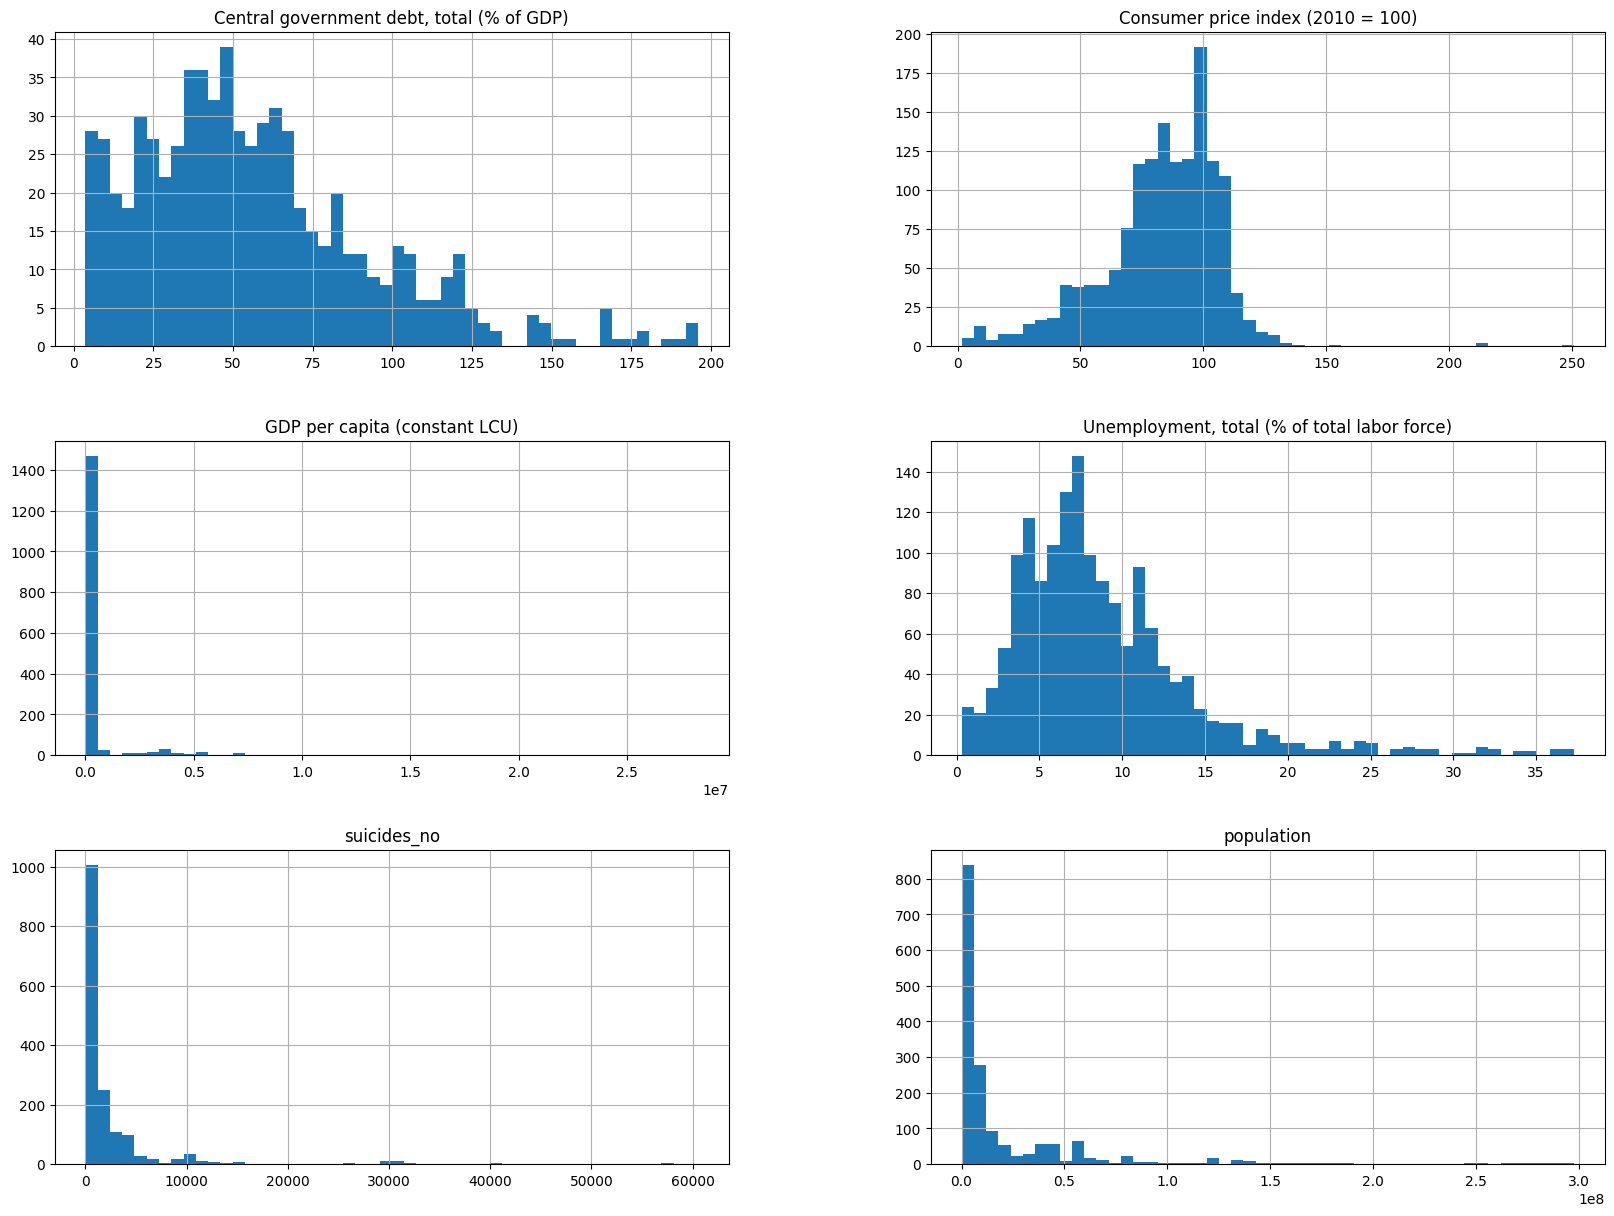

In [53]:
economics_data.hist(bins=50, figsize=(20,15))
plt.show()

In [55]:
economics_data.describe()

,"Central government debt, total (% of GDP)",Consumer price index (2010 = 100),GDP per capita (constant LCU),"Unemployment, total (% of total labor force)",suicides_no,population
count,681.000000,1479.000000,1.644000e+03,1577.000000,1654.000000,1.654000e+03
mean,56.676592,82.994576,7.143152e+05,8.794356,2929.029625,2.229644e+07
std,36.814464,23.962311,2.804038e+06,5.541547,7170.830242,4.196167e+07
min,3.675330,1.627491,4.364325e+02,0.300000,0.000000,2.380100e+04
25%,30.306790,71.519895,1.146569e+04,5.100000,139.000000,2.044640e+06
50%,49.776964,86.109598,3.455280e+04,7.600000,589.500000,5.547578e+06
75%,75.539374,100.000000,1.379862e+05,11.000000,2240.250000,2.087673e+07
max,195.992700,250.829327,2.829092e+07,37.299999,60548.000000,2.977497e+08


In [63]:
economics_data.to_csv("data/data_untreated.csv")